# Non-Unitary Operators for the Non-Hermitian Skin Effect

Paper to be replicated: https://arxiv.org/pdf/2311.10143

Addition Resources Consulted:
- https://link.aps.org/pdf/10.1103/PRXQuantum.2.010342
- https://medium.com/mdr-inc/time-evolution-operators-be2968493b86 (note there are some notable errors)
- 

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector

from tqdm.notebook import tqdm

from numpy import sin, cos
import numpy as np
from scipy.linalg import expm, sqrtm

from itertools import product

import random

import json



In [4]:
# service = QiskitRuntimeService()
BACKEND = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=BACKEND, optimization_level=0)
estimator = Estimator(backend=BACKEND)
sampler = Sampler(backend=BACKEND)

## I. Hatano-Nelson Model

Note $\hat{X}^+ = \frac{\hat{X} + i \hat{Y}}{2}$ and $\hat{X}^- = \frac{\hat{X} - i \hat{Y}}{2}$

In [5]:
X_gate = np.array([[0, 1], 
                   [1, 0]])

Y_gate = np.array([[0, -1j],
                   [1j, 0]])

I_gate = np.array([[1, 0], 
                   [0, 1]])

X_plus = 0.5 * (X_gate + 1j * Y_gate)
X_minus = 0.5 * (X_gate - 1j * Y_gate)

In [6]:
# Helper function, generates U_j_nonH
def get_U_j_nonH(J, gamma, index, N, timestep):
    product_1 = np.kron(X_plus, X_minus)
    product_2 = np.kron(X_minus, X_plus)
    exponent = 1j * timestep * ( (J - gamma) * product_1 + (J + gamma) * product_2)
    
    if index == 0:
        U_j_nonH = np.kron(np.eye(2 ** (N-2)), expm(exponent))
    if index == N - 2:
        U_j_nonH = np.kron(expm(exponent), np.eye(2 ** (N-2)))
    else: 
        U_j_nonH = np.kron(np.kron(np.eye(2 ** (N - 2 - index)), expm(exponent)), np.eye(2 ** (index)))
    return U_j_nonH
    


# Helper function, generates R_HN
def get_R_HN(J, gamma, N, timestep):
    res_even = np.eye(2 ** N)
    res_odd = np.eye(2 ** N)
    for i in range(N - 1):
        if i % 2 == 0:
            res_even = np.matmul(res_even, get_U_j_nonH(J, gamma, i, N, timestep))
        else:
            res_odd = np.matmul(res_odd, get_U_j_nonH(J, gamma, i, N, timestep))
    return np.matmul(res_even, res_odd)

# Generates U_HN 
def get_U_HN(J, gamma, N, timestep):
    R_HN = get_R_HN(J, gamma, N, timestep)

    A, sig, Bh = np.linalg.svd(R_HN)
    eigval, _ = np.linalg.eig(np.matmul(R_HN.conj().T, R_HN))
    u_square_inverse = max(eigval)
    u_square = 1/u_square_inverse 
    C = np.matmul(np.matmul(A, sqrtm(np.eye(2 ** N) - u_square * np.diag(np.square(sig)))), Bh)

    u_R_HN = np.sqrt(u_square) * R_HN
    W = np.concatenate((np.concatenate((u_R_HN, C), axis=0), np.concatenate((np.eye(2 ** N), np.eye(2 ** N)), axis=0)), axis=1)
    U_HN, _ = np.linalg.qr(W)
    return U_HN

In [7]:
def projection(N):
    projector = np.array([[1.0, 0.0], [0.0, 0.0]])
    
    return np.kron(projector, np.eye(2 ** (N-1)))

projection(3)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [8]:
total_time = 1.8
nb_timesteps = 10
timestep_duration = total_time/nb_timesteps

# First Attempt Using Gates
Note: This attempt missed out on implementing the projection between each trotter step, hence the non-unitary case where $gamma \neq 0.0$ gives the wrong figure.

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'T')

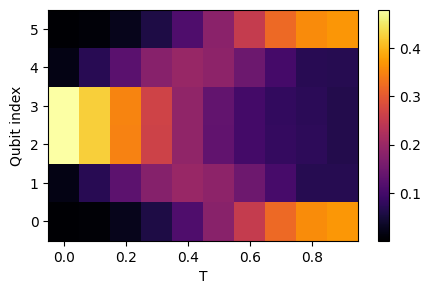

In [178]:
# For gamma = 0.0 case 
# (Original Implementation using individual UnitaryGates, but missed out projection between each trotter step)
N = 6

# Generate the unitary
matrix = get_U_HN(2, 0.0, N, 0.1)
gate = UnitaryGate(matrix)

# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    qc.h(N//2 - 1)
    qc.cx(N//2 - 1, N//2)
    
    gate = UnitaryGate(np.linalg.matrix_power(matrix, n_steps))
    qc.append(gate, [i for i in range(N+1)])
    
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '1':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

fig = plt.figure(figsize=(10/2,6/2), facecolor='white')
im = plt.pcolormesh([0.1 * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')



In [15]:
# For gamma = 0.5 case 
# (Original Implementation using individual UnitaryGates, but missed out projection between each trotter step)
N = 6

# Generate the unitary
matrix = get_U_HN(2, 0.5, N, 0.1)
gate = UnitaryGate(matrix)

# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    qc.h(N//2 - 1)
    qc.cx(N//2 - 1, N//2)
    
    gate = UnitaryGate(np.linalg.matrix_power(matrix, n_steps))
    qc.append(gate, [i for i in range(N+1)])
    
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '1':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'T')

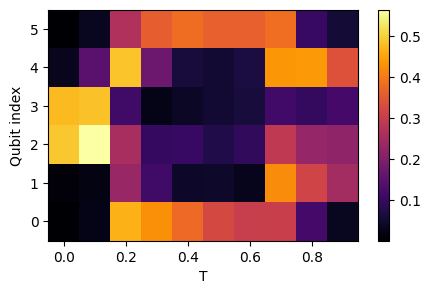

In [17]:
fig = plt.figure(figsize=(10/2,6/2), facecolor='white')
im = plt.pcolormesh([0.1 * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Second Attempt: Mathematical implementation of Fig 3a
Note: Qiskit was not used

(6, 10)


Text(0.5, 0, 'T')

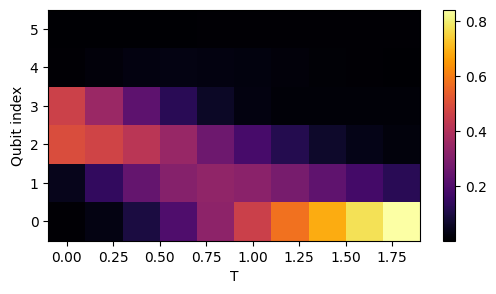

In [157]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

magnetization=[]
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Third Attempt: Adapting the Mathematical Representation to Qiskit
Note: the `Statevector` Class was used, however sampler was not used as far as I am aware.

The first attempt follows the method detailed in the paper. Since a second non-unitary operation (the projection between each trotter step) was necessary, I adopted using the `Statevector` class which came with an `evolve` method which can take non-unitary operators. However, I am not sure why we cannot use this directly with the non-unitary HN operator.


  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

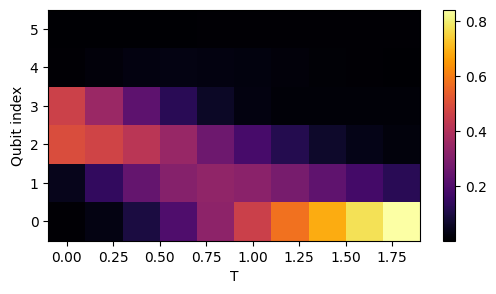

In [170]:
# For gamma = 0.5 case 
# Adapting the math representation to Qiskit
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_U_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        state = state.evolve(projector)
    
    # qc.measure_all()
    # circuits.append(qc)
    circuits.append(state)

# Execute measurements for paper's Fig 3a
density=[]
res_list = []
for circ in tqdm(circuits):
    # pubs = [(circ)]
    # job = sampler.run(pubs, shots=160000)
    # results = job.result()
    # res = results[0].data.meas.get_counts()
    probs = circ.probabilities()
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(probs[i])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

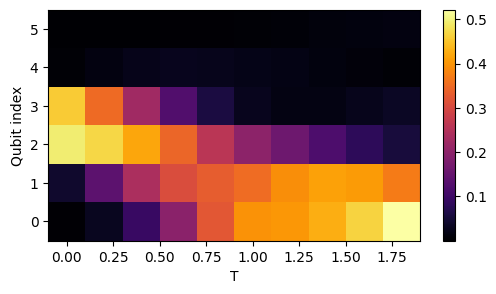

In [177]:
# For gamma = 0.5 case 
# Using R_HN directly
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_R_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        #state = state.evolve(projector)
    
    # qc.measure_all()
    # circuits.append(qc)
    circuits.append(state)

# Execute measurements for paper's Fig 3a
density=[]
res_list = []
for circ in tqdm(circuits):
    # pubs = [(circ)]
    # job = sampler.run(pubs, shots=160000)
    # results = job.result()
    # res = results[0].data.meas.get_counts()
    probs = circ.probabilities()
    state_dict = {}
    for i in range(2 ** (N)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N)] = np.abs(probs[i])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if True: #key[0] == '0':
            prob += value
            for i in range(0, N):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i - 1] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Fourth Attempt: Integrating Sampler (and hence adapting for execution on quantum computers)
This is similar to attempt 3, except the `Statevectors` are now made into circuits and `Sampler` can thus be used on them (as far as I am aware). However, my original question in attempt 3 remains, hence there is a second circuit under this attempt (also directly using `R_HN`)

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

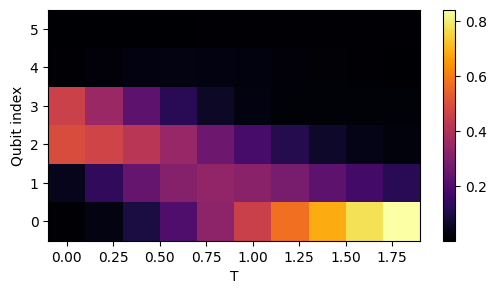

In [184]:
# For gamma = 0.5 case 
# Adapting the math representation to Qiskit
# Using Sampler
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_U_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        state = state.evolve(projector)
    
    qc.initialize(state, range(N+1), normalize=True)
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '0':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

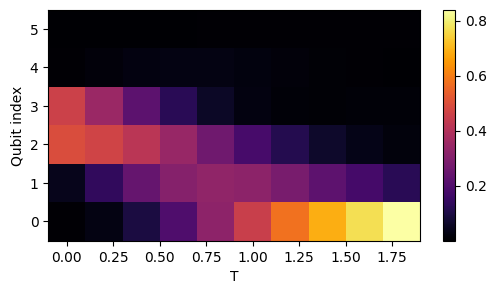

In [186]:
# For gamma = 0.5 case 
# Adapting the math representation to Qiskit
# Using Sampler
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_R_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N)
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        # state = state.evolve(projector)
    
    qc.initialize(state, range(N), normalize=True)
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if True: #key[0] == "0":
            counts_left += value

            for i in range(0, N):
                if key[i] == '0':
                    row[i] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Comparison (Fig S2)

(6, 10)


Text(0.5, 0, 'T')

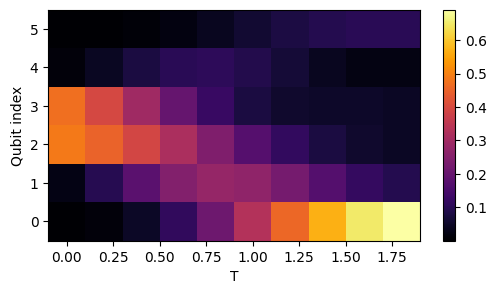

In [39]:
# For gamma = 0.2 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.2
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

magnetization=[]
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

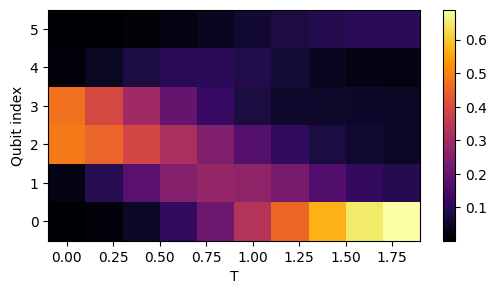

In [38]:
# For gamma = 0.2 case 
# Adapting the math representation to Qiskit
# Using Sampler
N = 6
J = 1
gamma = 0.2
timestep_duration = 0.2

# Generate the unitary
matrix = get_U_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        state = state.evolve(projector)
    
    qc.initialize(state, range(N+1), normalize=True)
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '0':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# nH-SSH Model

In [9]:
def get_N_total(N):
    return int(N + N/2)

In [10]:
def unitary(J, timestep):
    product_1 = np.kron(np.kron(X_gate, I_gate), X_gate)
    product_2 = np.kron(np.kron(Y_gate, I_gate), Y_gate)
    exponent = 1j * timestep * ( (J/2) * (product_1 + product_2))
    return expm(exponent)


def get_unitary(J, timestep, N):
    gate = unitary(J, timestep)
    matrix = np.kron(I_gate, I_gate)
    for _ in range(2, get_N_total(N) - 1, 3):
        matrix = np.kron(matrix, gate)
    matrix = np.kron(matrix, I_gate)
    return matrix


def get_all_U_R(J, gamma, N, timestep):
    gate = get_U_HN(J, gamma, 2, timestep)
    matrix = gate
    for _ in range(1, int(N/2)):
        matrix = np.kron(matrix, gate)
    return matrix

def get_all_projection(N):
    projection_matrix = projection(3)
    matrix = projection_matrix
    for _ in range(1, int(N/2)):
        matrix = np.kron(matrix, projection_matrix)
    return matrix


In [11]:
def check_ancillary(N, key):
    total_N = get_N_total(N)
    for i in range(total_N):
        if i % 3 == 0:
            if key[i] != "0":
                return False
    return True


In [16]:
def get_density(J, gamma, N, nb_timesteps, timestep_duration):
    total_N = get_N_total(N)

    # Generate the unitary
    matrix = get_all_U_R(J, gamma , N, timestep_duration)
    projection_matrix = get_all_projection(N)
    unitary_term = get_unitary(J, timestep_duration, N)

    # create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
    initial_vector = np.zeros((2**(total_N), 1), dtype=complex)
    binary_1 = "" #011" + "010" + "011
    binary_2 = ""
    for index in range(N):
        if index % 2 == 0:
            binary_1 += "0"
            binary_2 += "0"
        
        if index == N/2 - 1:
            binary_1 += "0"
            binary_2 += "1"
        elif index == N/2:
            binary_1 += "1"
            binary_2 += "0"
        else:
            binary_1 += "1"
            binary_2 += "1"
            
    initial_vector[int(binary_1, 2)] = 1/np.sqrt(2)
    initial_vector[int(binary_2, 2)] = 1/np.sqrt(2)

    magnetization=[]
    for n_steps in range(1, nb_timesteps + 1):

        # for each time step, apply the matrix n_steps times onto the initial vector
        state_vector = np.matmul(np.linalg.matrix_power(np.matmul(unitary_term, np.matmul(projection_matrix, matrix)), n_steps), initial_vector).T[0]
        state_dict = {}
        for i in range(2 ** (total_N)):

            # allocate the relevant probabilities to each state
            state_dict[bin(i)[2:].zfill(total_N)] = np.abs(state_vector[i]) ** 2

    
        # create a new row to add to magnetization array
        row = [0 for _ in range(N)]
        prob = 0
        for key, value in state_dict.items():

            # key[0] is the ancillary qubit
            if check_ancillary(N, key):
                prob += value
                for i in range(total_N):

                    # if the other qubits have a result of 0, then add the probabilities to that qubit
                    if i % 3 != 0:
                        if key[i] == '0':
                            real_index = i // 3 * 2 + i % 3
                            row[N - real_index] += value

        magnetization += [[x/prob for x in row]]
    return np.array(magnetization)

In [13]:

nb_timesteps = 10
timestep_duration = 0.1
gamma = 0.5
J = 2



In [17]:
density_6 = get_density(J, gamma, 6, nb_timesteps, timestep_duration)


In [18]:
density_8 = get_density(J, gamma, 8, nb_timesteps, timestep_duration)


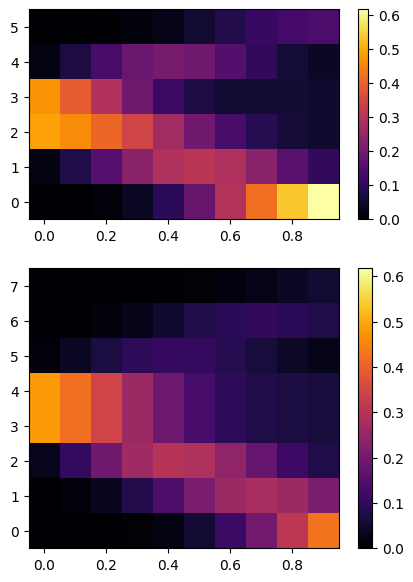

In [34]:
fig, axes = plt.subplots(2, height_ratios=[6, 8], figsize=(10/2, (6 + 8)/2))
plt.inferno()
im_0 = axes[0].pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,6,1), density_6.T, vmin=0, vmax=np.max(density_6))
im_1 = axes[1].pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,8,1), density_8.T, vmin=0, vmax=np.max(density_6))
fig.colorbar(im_0)
fig.colorbar(im_1)

Text(0.5, 0, 'T')

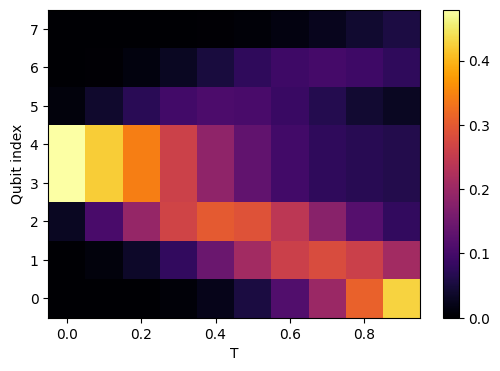

In [41]:
density_8 = magnetization
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), density_8.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')